<h2> Goals </h2>

The goal of this project is to build a data driven model that finds the customer groups that lead to good
ROIs (Return on Investment).

1. What percentage of campaigns led to group 1 being the most profitable? What about group 2? And neither of the groups?

2. Based on all the information you have, can you build a model to optimize future campaigns? Given the characteristics of two different groups of customers, please predict which group to target.

3. By how much do you think your model could improve campaign success rates? How would you test that?

4. Optional: Can you write an API for your model that the marketing IT team can call?

In [1]:
import sys
print(f'Python version: {sys.version}')

Python version: 3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from pprint import pprint
from scipy.stats import uniform, randint
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

In [3]:
df = pd.read_csv('data/customerGroups.csv')

In [4]:
df.head()

,g1_1,g1_2,g1_3,g1_4,g1_5,g1_6,g1_7,g1_8,g1_9,g1_10,...,c_20,c_21,c_22,c_23,c_24,c_25,c_26,c_27,c_28,target
0,4.50,1,3,4,5,1,1,4,6,0,...,-0.383704,-0.065449,0.584000,0.488000,0,-3.232000,-1.944000,-0.007944,1.76,2
1,2.20,24,22,46,10,24,28,18,22,-4,...,-0.346839,-0.159744,-0.947614,0.463540,0,-5.342174,-1.321355,0.181064,1.85,1
2,12.00,7,4,11,18,8,11,2,10,-3,...,-2.673934,-1.592303,0.525305,-0.467169,0,-6.566521,-4.176403,-0.040277,2.05,2
3,1.91,8,5,13,14,6,7,6,9,-1,...,0.616027,0.404945,-1.506923,0.741964,0,-2.438120,-0.787132,-0.012101,1.82,0
4,2.50,23,16,39,14,33,25,18,27,8,...,-1.057214,-1.159294,0.751012,-0.182052,0,-1.259728,0.059574,0.042613,1.99,2


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6620 entries, 0 to 6619
Data columns (total 71 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   g1_1    6620 non-null   float64
 1   g1_2    6620 non-null   int64  
 2   g1_3    6620 non-null   int64  
 3   g1_4    6620 non-null   int64  
 4   g1_5    6620 non-null   int64  
 5   g1_6    6620 non-null   int64  
 6   g1_7    6620 non-null   int64  
 7   g1_8    6620 non-null   int64  
 8   g1_9    6620 non-null   int64  
 9   g1_10   6620 non-null   int64  
 10  g1_11   6620 non-null   int64  
 11  g1_12   6620 non-null   int64  
 12  g1_13   6620 non-null   float64
 13  g1_14   6620 non-null   float64
 14  g1_15   6620 non-null   float64
 15  g1_16   6620 non-null   float64
 16  g1_17   6620 non-null   float64
 17  g1_18   6620 non-null   float64
 18  g1_19   6620 non-null   float64
 19  g1_20   6620 non-null   float64
 20  g1_21   6620 non-null   float64
 21  g2_1    6620 non-null   float64
 22  

In [6]:
df['target'] = df['target'].astype('category')

In [7]:
df.describe()

,g1_1,g1_2,g1_3,g1_4,g1_5,g1_6,g1_7,g1_8,g1_9,g1_10,...,c_19,c_20,c_21,c_22,c_23,c_24,c_25,c_26,c_27,c_28
count,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,...,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.00000,6620.000000,6620.000000,6620.000000,6620.000000
mean,2.708779,14.424018,10.485650,24.909668,10.988066,13.412085,10.161027,10.745468,14.169033,3.251057,...,-0.332175,-0.029311,-0.006724,-0.004147,0.008827,0.00000,-0.228426,-0.103728,0.000408,1.917134
std,1.857725,10.700787,8.384203,18.174948,5.635985,10.090030,7.495039,7.964247,9.866734,8.481210,...,21.498095,1.220752,1.068199,0.663238,0.683422,0.32287,3.390902,1.944419,0.092761,0.302175
min,1.050000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-27.000000,...,-101.000000,-4.684111,-4.319826,-2.512919,-3.118836,-2.00000,-15.202740,-9.181722,-0.750000,0.000000
25%,1.667000,6.000000,4.000000,10.000000,6.000000,5.000000,4.000000,4.000000,6.000000,-2.000000,...,-10.000000,-0.716407,-0.531224,-0.440407,-0.406811,0.00000,-2.222226,-1.293471,-0.054331,1.710000
50%,2.150000,13.000000,9.000000,22.000000,11.000000,12.000000,9.000000,9.000000,13.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.001070,0.00000,-0.119378,-0.012487,0.000000,1.850000
75%,2.800000,21.000000,15.000000,36.000000,16.000000,20.000000,15.000000,16.000000,21.000000,7.000000,...,10.000000,0.654627,0.490504,0.410915,0.450104,0.00000,1.809334,1.035235,0.054825,2.020000
max,23.000000,52.000000,47.000000,94.000000,20.000000,61.000000,43.000000,48.000000,52.000000,48.000000,...,108.000000,4.821136,4.396281,2.987136,2.830550,2.00000,12.562698,8.209578,0.666667,4.330000


array([[<AxesSubplot:title={'center':'g1_1'}>,
        <AxesSubplot:title={'center':'g1_2'}>,
        <AxesSubplot:title={'center':'g1_3'}>,
        <AxesSubplot:title={'center':'g1_4'}>,
        <AxesSubplot:title={'center':'g1_5'}>,
        <AxesSubplot:title={'center':'g1_6'}>,
        <AxesSubplot:title={'center':'g1_7'}>,
        <AxesSubplot:title={'center':'g1_8'}>],
       [<AxesSubplot:title={'center':'g1_9'}>,
        <AxesSubplot:title={'center':'g1_10'}>,
        <AxesSubplot:title={'center':'g1_11'}>,
        <AxesSubplot:title={'center':'g1_12'}>,
        <AxesSubplot:title={'center':'g1_13'}>,
        <AxesSubplot:title={'center':'g1_14'}>,
        <AxesSubplot:title={'center':'g1_15'}>,
        <AxesSubplot:title={'center':'g1_16'}>],
       [<AxesSubplot:title={'center':'g1_17'}>,
        <AxesSubplot:title={'center':'g1_18'}>,
        <AxesSubplot:title={'center':'g1_19'}>,
        <AxesSubplot:title={'center':'g1_20'}>,
        <AxesSubplot:title={'center':'g1_21'}>,

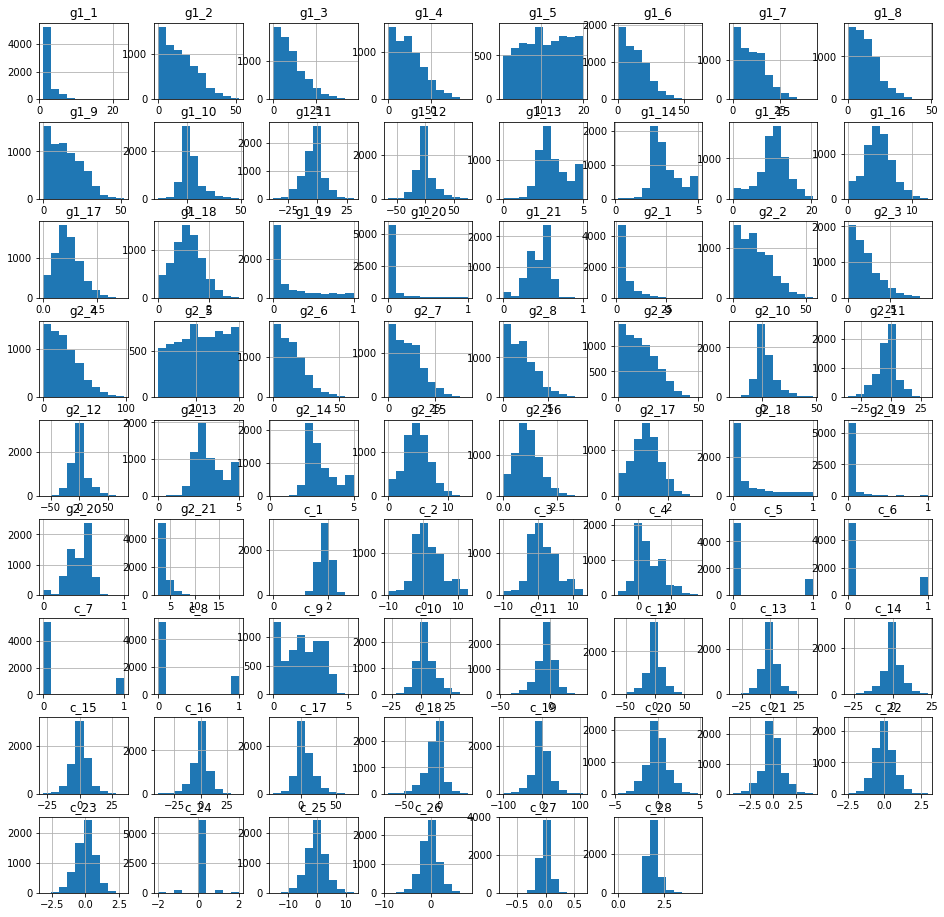

In [8]:
df.hist(figsize=(16,16))

As we can see histograms looks pretty good. We can see some outliers in g1_1, g2_9, c_6, g2_21, c_1 columns. In this approach, I will assume that they are a natural part of the population, since I don't really know the meaning of the features.

<h2> What percentage of campaigns led to group 1 being the most profitable? What about group 2?
And neither of the groups? </h2>

In [9]:
print(df['target'].value_counts())

np.sum(df['target'].value_counts())

1    3076
2    1877
0    1667
Name: target, dtype: int64


6620

In [10]:
df_mostprofitable = pd.DataFrame.from_dict({'group 1': 3076/6620, 'group 2': 1877 / 6620, 'neither': 1667 / 6620}, orient='index', columns=['percentage'])

In [11]:
df_mostprofitable

,percentage
group 1,0.464653
group 2,0.283535
neither,0.251813


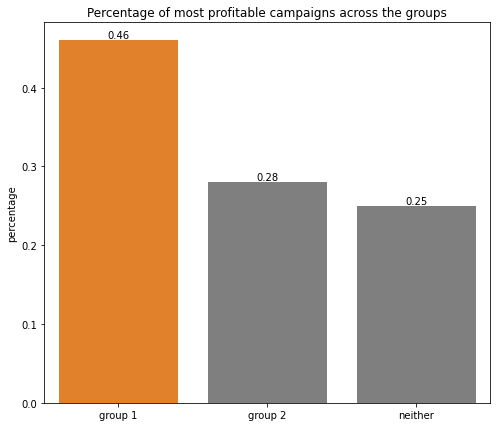

In [12]:
f, ax = plt.subplots(figsize=(8, 7))

ax = sns.barplot(x=df_mostprofitable.index, y=df_mostprofitable['percentage'].round(2), palette = ['tab:orange', 'tab:grey', 'tab:grey'],
                 errwidth=0)

ax.set(title='Percentage of most profitable campaigns across the groups')
ax.bar_label(ax.containers[0])

plt.show()

As we can see 46% of campaigns that led to group 1 are the most profitable, 28% that led to group 2, and 25% for which none of the groups are profitable.

<h2> Based on all the information you have, can you build a model to optimize future campaigns?
Given the characteristics of two different groups of customers, please predict which group to
target. </h2>

<h3> Prepare dataset </h3>

In [13]:
df_grouped = df.loc[df['target'] != 0]

In [14]:
X_ =  df_grouped.to_numpy()
X, y = X_[:, :-1], X_[:, -1]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
scaler = StandardScaler()

In [17]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

<h3> Models </h3>

We can look at [1] to choose a proper estimator. Since dataset is small, we can try to tune more models than usual.
Let's try with Linear SVC first.

<p>Linear SVC </p>

Note: [2] LinearSVC, algorithm takes longer as usual if we require a very high precision, which is controlled
by tolerance hyperparameter tol. In most cases the default tolerance is fine.

Note: [2] It’s recommended to use LinearSVC(C=1, loss="hinge"). Make sure to set loss to hinge.
For better performance set dual to False, unless there are more features than training
instances.

I will also use some tips from [3].

Our scoring metric will be AUC ROC, since it's one of the good choices for imbalanced datasets.

<p>_Tuning 1 </p>

In [217]:
clf = LinearSVC(class_weight='balanced', max_iter=500000, random_state=42)

In [218]:
param_grid = [{'C': [0.001, 0.003, 0.01, 0.3, 1], 'penalty': ['l1'], 'loss': ['squared_hinge'], 'dual': [False]},
              {'C': [0.001, 0.003, 0.01, 0.3, 1], 'penalty': ['l2'], 'loss': ['hinge'], 'dual': [True]}]

In [219]:
search = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=1, scoring='roc_auc')
search.fit(X_train, y_train)
print(search.best_score_)
pprint(search.cv_results_['mean_test_score'])
pprint(search.cv_results_['params'])

0.8346810978988328
array([0.83003926, 0.83332519, 0.8346811 , 0.8301191 , 0.82935557,
       0.82397549, 0.82911182, 0.82974017, 0.82688237, 0.82671213])
[{'C': 0.001, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l1'},
 {'C': 0.003, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l1'},
 {'C': 0.01, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l1'},
 {'C': 0.3, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l1'},
 {'C': 1, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l1'},
 {'C': 0.001, 'dual': True, 'loss': 'hinge', 'penalty': 'l2'},
 {'C': 0.003, 'dual': True, 'loss': 'hinge', 'penalty': 'l2'},
 {'C': 0.01, 'dual': True, 'loss': 'hinge', 'penalty': 'l2'},
 {'C': 0.3, 'dual': True, 'loss': 'hinge', 'penalty': 'l2'},
 {'C': 1, 'dual': True, 'loss': 'hinge', 'penalty': 'l2'}]


In [220]:
print(search.best_params_)

{'C': 0.01, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l1'}


</p>_Tuning 2</p>

In [221]:
param_grid = [{'C': uniform(0.003, 0.027), 'penalty': ['l1'], 'loss': ['squared_hinge'], 'dual': [False]}]

In [222]:
search = RandomizedSearchCV(clf, param_distributions=param_grid, cv=5, n_jobs=1, scoring='roc_auc')
search.fit(X_train, y_train)
print(search.best_score_)
pprint(search.cv_results_['mean_test_score'])
pprint(search.cv_results_['params'])

0.8347663219533319
array([0.83449697, 0.83457562, 0.8333602 , 0.83339823, 0.83322209,
       0.83283073, 0.83476632, 0.83356405, 0.83380099, 0.83403286])
[{'C': 0.005218854257417124,
  'dual': False,
  'loss': 'squared_hinge',
  'penalty': 'l1'},
 {'C': 0.011866571978731925,
  'dual': False,
  'loss': 'squared_hinge',
  'penalty': 'l1'},
 {'C': 0.02032964255330196,
  'dual': False,
  'loss': 'squared_hinge',
  'penalty': 'l1'},
 {'C': 0.019559605770868013,
  'dual': False,
  'loss': 'squared_hinge',
  'penalty': 'l1'},
 {'C': 0.021568123761405655,
  'dual': False,
  'loss': 'squared_hinge',
  'penalty': 'l1'},
 {'C': 0.028216308163995285,
  'dual': False,
  'loss': 'squared_hinge',
  'penalty': 'l1'},
 {'C': 0.008571971195077212,
  'dual': False,
  'loss': 'squared_hinge',
  'penalty': 'l1'},
 {'C': 0.0034564923490128133,
  'dual': False,
  'loss': 'squared_hinge',
  'penalty': 'l1'},
 {'C': 0.0036306346439824474,
  'dual': False,
  'loss': 'squared_hinge',
  'penalty': 'l1'},
 {'C': 0

In [223]:
print(search.best_params_)

{'C': 0.008571971195077212, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l1'}


It looks like further tuning doesn't make sense. We received an imperceptibly better model and there is no sensible hyperparameter spaces to check through.

<p> _Tuned model </p>

In [18]:
LinearSVC_clf = LinearSVC(class_weight='balanced', C=0.008, penalty='l1', loss='squared_hinge', dual=False, max_iter=500000, random_state=42)

In [56]:
LinearSVC_clf.fit(X_train, y_train)

LinearSVC(C=0.008, class_weight='balanced', dual=False, max_iter=500000,
          penalty='l1', random_state=42)

In [57]:
X_test.shape, y_test.shape

((991, 70), (991,))

In [58]:
print(roc_auc_score(y_train-1, LinearSVC_clf._predict_proba_lr(X_train)[:, 1]))
roc_auc_score(y_test-1, LinearSVC_clf._predict_proba_lr(X_test)[:, 1])

0.8382866908179033


0.832911535028038

In [59]:
data_LinearSVC = {'ROC_AUC train': [0.84], 'ROC_AUC val': [0.83], 'ROC_AUC test': [0.83]}
data_LinearSVC = pd.DataFrame(data_LinearSVC, index=['LinearSVC'])
data_LinearSVC

,ROC_AUC train,ROC_AUC val,ROC_AUC test
LinearSVC,0.84,0.83,0.83


This is quite a good result, and there is no overfitting or underfitting.

However, let's try a different model.

<p> KNeighborsClassifier </p>

In [257]:
clf = KNeighborsClassifier()

<p> _Tuning 1 </p>

In [260]:
param_grid = {'n_neighbors': [3, 4, 5, 6, 7, 8], 'weights': ['uniform', 'distance', None], 'p': [1,2]}

In [261]:
search = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=1, scoring='roc_auc')
search.fit(X_train, y_train)
print(search.best_score_)
pprint(search.cv_results_['mean_test_score'])
pprint(search.cv_results_['params'])

0.7623877666438024
array([0.70810258, 0.70891101, 0.70810258, 0.7104262 , 0.71039692,
       0.7104262 , 0.72226215, 0.72304319, 0.72226215, 0.72595661,
       0.72712956, 0.72595661, 0.73199624, 0.73425133, 0.73199624,
       0.73727425, 0.73848227, 0.73727425, 0.74513016, 0.74545488,
       0.74513016, 0.74604595, 0.74753847, 0.74604595, 0.75021913,
       0.75084158, 0.75021913, 0.75579145, 0.75671187, 0.75579145,
       0.75577081, 0.75666442, 0.75577081, 0.7618238 , 0.76238777,
       0.7618238 ])
[{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'},
 {'n_neighbors': 3, 'p': 1, 'weights': 'distance'},
 {'n_neighbors': 3, 'p': 1, 'weights': None},
 {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'},
 {'n_neighbors': 3, 'p': 2, 'weights': 'distance'},
 {'n_neighbors': 3, 'p': 2, 'weights': None},
 {'n_neighbors': 4, 'p': 1, 'weights': 'uniform'},
 {'n_neighbors': 4, 'p': 1, 'weights': 'distance'},
 {'n_neighbors': 4, 'p': 1, 'weights': None},
 {'n_neighbors': 4, 'p': 2, 'weights': 'unifo

In [262]:
print(search.best_params_)

{'n_neighbors': 8, 'p': 2, 'weights': 'distance'}


<p> _Tuning 2 </p>

In [263]:
param_grid = {'n_neighbors': [8, 9, 10, 11, 12, 13], 'weights': ['uniform', 'distance', None], 'p': [2]}

In [264]:
search = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=1, scoring='roc_auc')
search.fit(X_train, y_train)
print(search.best_score_)
pprint(search.cv_results_['mean_test_score'])
pprint(search.cv_results_['params'])

0.7770419386554429
array([0.7618238 , 0.76238777, 0.7618238 , 0.76564943, 0.7661636 ,
       0.76564943, 0.76700064, 0.76799261, 0.76700064, 0.77180656,
       0.77199151, 0.77180656, 0.7741557 , 0.77466996, 0.7741557 ,
       0.7765279 , 0.77704194, 0.7765279 ])
[{'n_neighbors': 8, 'p': 2, 'weights': 'uniform'},
 {'n_neighbors': 8, 'p': 2, 'weights': 'distance'},
 {'n_neighbors': 8, 'p': 2, 'weights': None},
 {'n_neighbors': 9, 'p': 2, 'weights': 'uniform'},
 {'n_neighbors': 9, 'p': 2, 'weights': 'distance'},
 {'n_neighbors': 9, 'p': 2, 'weights': None},
 {'n_neighbors': 10, 'p': 2, 'weights': 'uniform'},
 {'n_neighbors': 10, 'p': 2, 'weights': 'distance'},
 {'n_neighbors': 10, 'p': 2, 'weights': None},
 {'n_neighbors': 11, 'p': 2, 'weights': 'uniform'},
 {'n_neighbors': 11, 'p': 2, 'weights': 'distance'},
 {'n_neighbors': 11, 'p': 2, 'weights': None},
 {'n_neighbors': 12, 'p': 2, 'weights': 'uniform'},
 {'n_neighbors': 12, 'p': 2, 'weights': 'distance'},
 {'n_neighbors': 12, 'p': 2, 

In [265]:
print(search.best_params_)

{'n_neighbors': 13, 'p': 2, 'weights': 'distance'}


<p> _Tuning 3 </p>

In [267]:
param_grid = {'n_neighbors': [15, 20, 25, 30, 35], 'weights': ['uniform', 'distance', None], 'p': [2]}

In [268]:
search = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=1, scoring='roc_auc')
search.fit(X_train, y_train)
print(search.best_score_)
pprint(search.cv_results_['mean_test_score'])
pprint(search.cv_results_['params'])

0.7896865813115675
array([0.77992683, 0.78034551, 0.77992683, 0.78631599, 0.78700448,
       0.78631599, 0.78712059, 0.78822088, 0.78712059, 0.78766869,
       0.78876696, 0.78766869, 0.7886251 , 0.78968658, 0.7886251 ])
[{'n_neighbors': 15, 'p': 2, 'weights': 'uniform'},
 {'n_neighbors': 15, 'p': 2, 'weights': 'distance'},
 {'n_neighbors': 15, 'p': 2, 'weights': None},
 {'n_neighbors': 20, 'p': 2, 'weights': 'uniform'},
 {'n_neighbors': 20, 'p': 2, 'weights': 'distance'},
 {'n_neighbors': 20, 'p': 2, 'weights': None},
 {'n_neighbors': 25, 'p': 2, 'weights': 'uniform'},
 {'n_neighbors': 25, 'p': 2, 'weights': 'distance'},
 {'n_neighbors': 25, 'p': 2, 'weights': None},
 {'n_neighbors': 30, 'p': 2, 'weights': 'uniform'},
 {'n_neighbors': 30, 'p': 2, 'weights': 'distance'},
 {'n_neighbors': 30, 'p': 2, 'weights': None},
 {'n_neighbors': 35, 'p': 2, 'weights': 'uniform'},
 {'n_neighbors': 35, 'p': 2, 'weights': 'distance'},
 {'n_neighbors': 35, 'p': 2, 'weights': None}]


In [269]:
print(search.best_params_)

{'n_neighbors': 35, 'p': 2, 'weights': 'distance'}


<p> _Tuning 4 </p>

In [270]:
param_grid = {'n_neighbors': [50, 100, 150, 200], 'weights': ['uniform', 'distance', None], 'p': [2]}

In [271]:
search = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=1, scoring='roc_auc')
search.fit(X_train, y_train)
print(search.best_score_)
pprint(search.cv_results_['mean_test_score'])
pprint(search.cv_results_['params'])

0.7948206845292534
array([0.79140318, 0.79250834, 0.79140318, 0.79349564, 0.79479697,
       0.79349564, 0.79313666, 0.79467406, 0.79313666, 0.79344997,
       0.79482068, 0.79344997])
[{'n_neighbors': 50, 'p': 2, 'weights': 'uniform'},
 {'n_neighbors': 50, 'p': 2, 'weights': 'distance'},
 {'n_neighbors': 50, 'p': 2, 'weights': None},
 {'n_neighbors': 100, 'p': 2, 'weights': 'uniform'},
 {'n_neighbors': 100, 'p': 2, 'weights': 'distance'},
 {'n_neighbors': 100, 'p': 2, 'weights': None},
 {'n_neighbors': 150, 'p': 2, 'weights': 'uniform'},
 {'n_neighbors': 150, 'p': 2, 'weights': 'distance'},
 {'n_neighbors': 150, 'p': 2, 'weights': None},
 {'n_neighbors': 200, 'p': 2, 'weights': 'uniform'},
 {'n_neighbors': 200, 'p': 2, 'weights': 'distance'},
 {'n_neighbors': 200, 'p': 2, 'weights': None}]


In [272]:
print(search.best_params_)

{'n_neighbors': 200, 'p': 2, 'weights': 'distance'}


<p> _Tuning 5 </p>

In [273]:
param_grid = {'n_neighbors': [250, 500, 750, 1000], 'weights': ['uniform', 'distance', None], 'p': [2]}

In [274]:
search = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=1, scoring='roc_auc')
search.fit(X_train, y_train)
print(search.best_score_)
pprint(search.cv_results_['mean_test_score'])
pprint(search.cv_results_['params'])

0.7938745766539612
array([0.79246295, 0.79387458, 0.79246295, 0.78896019, 0.79070989,
       0.78896019, 0.785245  , 0.78741301, 0.785245  , 0.78056286,
       0.78373742, 0.78056286])
[{'n_neighbors': 250, 'p': 2, 'weights': 'uniform'},
 {'n_neighbors': 250, 'p': 2, 'weights': 'distance'},
 {'n_neighbors': 250, 'p': 2, 'weights': None},
 {'n_neighbors': 500, 'p': 2, 'weights': 'uniform'},
 {'n_neighbors': 500, 'p': 2, 'weights': 'distance'},
 {'n_neighbors': 500, 'p': 2, 'weights': None},
 {'n_neighbors': 750, 'p': 2, 'weights': 'uniform'},
 {'n_neighbors': 750, 'p': 2, 'weights': 'distance'},
 {'n_neighbors': 750, 'p': 2, 'weights': None},
 {'n_neighbors': 1000, 'p': 2, 'weights': 'uniform'},
 {'n_neighbors': 1000, 'p': 2, 'weights': 'distance'},
 {'n_neighbors': 1000, 'p': 2, 'weights': None}]


In [275]:
print(search.best_params_)

{'n_neighbors': 250, 'p': 2, 'weights': 'distance'}


<p> _Tuning 6 </p>

In [276]:
param_grid = {'n_neighbors': [170, 190, 210, 230], 'weights': ['uniform', 'distance', None], 'p': [2]}

In [277]:
search = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=1, scoring='roc_auc')
search.fit(X_train, y_train)
print(search.best_score_)
pprint(search.cv_results_['mean_test_score'])
pprint(search.cv_results_['params'])

0.7947646771802686
array([0.79321341, 0.79471871, 0.79321341, 0.79285097, 0.79430163,
       0.79285097, 0.79355452, 0.79476468, 0.79355452, 0.79231925,
       0.79381682, 0.79231925])
[{'n_neighbors': 170, 'p': 2, 'weights': 'uniform'},
 {'n_neighbors': 170, 'p': 2, 'weights': 'distance'},
 {'n_neighbors': 170, 'p': 2, 'weights': None},
 {'n_neighbors': 190, 'p': 2, 'weights': 'uniform'},
 {'n_neighbors': 190, 'p': 2, 'weights': 'distance'},
 {'n_neighbors': 190, 'p': 2, 'weights': None},
 {'n_neighbors': 210, 'p': 2, 'weights': 'uniform'},
 {'n_neighbors': 210, 'p': 2, 'weights': 'distance'},
 {'n_neighbors': 210, 'p': 2, 'weights': None},
 {'n_neighbors': 230, 'p': 2, 'weights': 'uniform'},
 {'n_neighbors': 230, 'p': 2, 'weights': 'distance'},
 {'n_neighbors': 230, 'p': 2, 'weights': None}]


In [278]:
print(search.best_params_)

{'n_neighbors': 210, 'p': 2, 'weights': 'distance'}


We guess that, we can't do much more with this model. The best score so far is 0.79 for n_neighbors=200.

<p> _Tuned model </p>

In [19]:
KNeighborsClassifier_clf = KNeighborsClassifier(n_neighbors=200, weights='distance', p=2)

In [61]:
KNeighborsClassifier_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=200, weights='distance')

In [62]:
X_test.shape, y_test.shape

((991, 70), (991,))

In [63]:
print(roc_auc_score(y_train-1, KNeighborsClassifier_clf.predict_proba(X_train)[:, 1]))
roc_auc_score(y_test-1, KNeighborsClassifier_clf.predict_proba(X_test)[:, 1])

1.0


0.7860052522556098

In [64]:
data_KNeighborsClassifier = {'ROC_AUC train': [1.00], 'ROC_AUC val': [0.79], 'ROC_AUC test': [0.79]}
data_KNeighborsClassifier = pd.DataFrame(data_KNeighborsClassifier, index=['KNeighborsClassifier'])
data_KNeighborsClassifier

,ROC_AUC train,ROC_AUC val,ROC_AUC test
KNeighborsClassifier,1.0,0.79,0.79


Here we have an overfitting. We can avoid it f.e. by simplifying the model, reducing the number of features, gathering more data, or reducing the noise in training data.

The easiest solution will be to try other models. Let's try SVC now.

<p> SVC </p>

Note: [2] SVC is perfect for complex but small or medium training sets. Also, it scales well with the
number of features, espeically with sparse features.

In [289]:
clf = SVC(random_state=42)

<p> _Tuning 1 </p>

In [292]:
param_grid = {'C': [0.001, 0.003, 0.01, 0.3, 1], 'kernel':
              ['linear', 'poly','rbf', 'sigmoid'],
             'gamma': ['scale', 'auto'], 'class_weight': ['balanced']}

In [293]:
search = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=1, scoring='roc_auc')
search.fit(X_train, y_train)
print(search.best_score_)
pprint(search.cv_results_['mean_test_score'])
pprint(search.cv_results_['params'])

0.8298278215488477
array([0.82404859, 0.76774777, 0.7757943 , 0.7742177 , 0.82404859,
       0.7677099 , 0.77578752, 0.77422716, 0.8293483 , 0.77202381,
       0.7757943 , 0.78167115, 0.8293483 , 0.77199273, 0.77578752,
       0.78167522, 0.82982782, 0.7794347 , 0.77981588, 0.79680317,
       0.82982782, 0.77946042, 0.7798159 , 0.79676669, 0.82681877,
       0.80153792, 0.82261964, 0.69793519, 0.82681877, 0.80153385,
       0.82262638, 0.69790946, 0.82673106, 0.79542011, 0.82340471,
       0.68366674, 0.82673106, 0.79547694, 0.82337361, 0.68371909])
[{'C': 0.001, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'},
 {'C': 0.001, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'poly'},
 {'C': 0.001, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'},
 {'C': 0.001,
  'class_weight': 'balanced',
  'gamma': 'scale',
  'kernel': 'sigmoid'},
 {'C': 0.001, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'linear'},
 {'C': 0.001, 'class_weight': 'balance

In [294]:
print(search.best_params_)

{'C': 0.01, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}


<p> _Tuning 2 </p>

In [296]:
param_grid = {'C': uniform(0.004, 0.016), 'kernel':
              ['linear', 'poly','rbf'],
             'gamma': ['scale', 'auto'], 'class_weight': ['balanced']}

In [297]:
search = RandomizedSearchCV(clf, param_distributions=param_grid, cv=5, n_jobs=1, scoring='roc_auc')
search.fit(X_train, y_train)
print(search.best_score_)
pprint(search.cv_results_['mean_test_score'])
pprint(search.cv_results_['params'])

0.8297708451228066
array([0.7843694 , 0.77765501, 0.78209744, 0.82964645, 0.77583214,
       0.7793033 , 0.78465489, 0.82977085, 0.78386694, 0.77748369])
[{'C': 0.015740751766869572,
  'class_weight': 'balanced',
  'gamma': 'auto',
  'kernel': 'poly'},
 {'C': 0.008014020617934162,
  'class_weight': 'balanced',
  'gamma': 'auto',
  'kernel': 'poly'},
 {'C': 0.012384332576230287,
  'class_weight': 'balanced',
  'gamma': 'scale',
  'kernel': 'poly'},
 {'C': 0.014261129795698223,
  'class_weight': 'balanced',
  'gamma': 'scale',
  'kernel': 'linear'},
 {'C': 0.005399213212432855,
  'class_weight': 'balanced',
  'gamma': 'auto',
  'kernel': 'rbf'},
 {'C': 0.009400717876929542,
  'class_weight': 'balanced',
  'gamma': 'scale',
  'kernel': 'rbf'},
 {'C': 0.016296127888363578,
  'class_weight': 'balanced',
  'gamma': 'auto',
  'kernel': 'poly'},
 {'C': 0.012223798392364017,
  'class_weight': 'balanced',
  'gamma': 'scale',
  'kernel': 'linear'},
 {'C': 0.014507512919195154,
  'class_weight': '

In [298]:
print(search.best_params_)

{'C': 0.012223798392364017, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}


Model from tuning 1 is better. Let's do a prediction on a test set.

<p> _Tuned model </p>

In [20]:
SVC_clf = SVC(C=0.01, class_weight='balanced', gamma='scale', kernel='linear', random_state=42, probability=True)

In [67]:
SVC_clf.fit(X_train, y_train)

SVC(C=0.01, class_weight='balanced', kernel='linear', probability=True,
    random_state=42)

In [68]:
X_test.shape, y_test.shape

((991, 70), (991,))

In [69]:
print(roc_auc_score(y_train-1, SVC_clf.predict_proba(X_train)[:, 1]))
roc_auc_score(y_test-1, SVC_clf.predict_proba(X_test)[:, 1])

0.8397535956959606


0.8310676119571152

In [71]:
data_SVC = {'ROC_AUC train': [0.84], 'ROC_AUC val': [0.83],'ROC_AUC test': [0.83]}
data_SVC = pd.DataFrame(data_SVC, index=['SVC'])
data_SVC

,ROC_AUC train,ROC_AUC val,ROC_AUC test
SVC,0.84,0.83,0.83


This time, no under or overfitting.

Let's try to create ensemble classifier, to get even better results.

<p> Ensemble methods </p>

<p> Random Forest </p>

RandomForestClassifier has a lot of hyperparameters. Let's focus on the most important ones at first.

In [22]:
clf = RandomForestClassifier(random_state=42)

<p> _Tuning 1 </p>

In [23]:
param_grid = {'n_estimators': randint(20,180)}

In [24]:
search = RandomizedSearchCV(clf, param_distributions=param_grid, cv=5, n_jobs=1, scoring='roc_auc')
search.fit(X_train, y_train)
print(search.best_score_)
pprint(search.cv_results_['mean_test_score'])
pprint(search.cv_results_['params'])

0.82673734562609
array([0.82599181, 0.82567079, 0.82539402, 0.82599181, 0.82587499,
       0.82566172, 0.82136776, 0.82186533, 0.82673735, 0.82380122])
[{'n_estimators': 127},
 {'n_estimators': 118},
 {'n_estimators': 111},
 {'n_estimators': 127},
 {'n_estimators': 124},
 {'n_estimators': 98},
 {'n_estimators': 34},
 {'n_estimators': 56},
 {'n_estimators': 148},
 {'n_estimators': 76}]


In [25]:
print(search.best_params_)

{'n_estimators': 148}


<p> _Tuning 2 </p>

In [26]:
param_grid = {'n_estimators': randint(150,250)}

In [27]:
search = RandomizedSearchCV(clf, param_distributions=param_grid, cv=5, n_jobs=1, scoring='roc_auc')
search.fit(X_train, y_train)
print(search.best_score_)
pprint(search.cv_results_['mean_test_score'])
pprint(search.cv_results_['params'])

0.8273587242991776
array([0.82673921, 0.82726429, 0.82711718, 0.82673167, 0.82717275,
       0.82677084, 0.82675433, 0.82735872, 0.82716602, 0.82671077])
[{'n_estimators': 158},
 {'n_estimators': 248},
 {'n_estimators': 164},
 {'n_estimators': 189},
 {'n_estimators': 221},
 {'n_estimators': 198},
 {'n_estimators': 150},
 {'n_estimators': 238},
 {'n_estimators': 222},
 {'n_estimators': 155}]


In [28]:
print(search.best_params_)

{'n_estimators': 238}


Slightly better result. It's time tu tune another hyperparameter.

<p> _Tuning 3 </p>

In [29]:
param_grid = {'n_estimators': [238], 'max_features': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

In [30]:
search = RandomizedSearchCV(clf, param_distributions=param_grid, cv=5, n_jobs=1, scoring='roc_auc')
search.fit(X_train, y_train)
print(search.best_score_)
pprint(search.cv_results_['mean_test_score'])
pprint(search.cv_results_['params'])

0.829230564525503
array([0.82723171, 0.80135017, 0.81093649, 0.81926117, 0.82481016,
       0.82706144, 0.82595066, 0.82698262, 0.82735872, 0.82923056])
[{'max_features': None, 'n_estimators': 238},
 {'max_features': 1, 'n_estimators': 238},
 {'max_features': 2, 'n_estimators': 238},
 {'max_features': 3, 'n_estimators': 238},
 {'max_features': 4, 'n_estimators': 238},
 {'max_features': 5, 'n_estimators': 238},
 {'max_features': 6, 'n_estimators': 238},
 {'max_features': 7, 'n_estimators': 238},
 {'max_features': 8, 'n_estimators': 238},
 {'max_features': 9, 'n_estimators': 238}]


In [31]:
print(search.best_params_)

{'n_estimators': 238, 'max_features': 9}


<p> _Tuning 4 </p>

In [32]:
param_grid = {'n_estimators': [238], 'max_features': [9, 13, 17, 21]}

In [34]:
search = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=1, scoring='roc_auc')
search.fit(X_train, y_train)
print(search.best_score_)
pprint(search.cv_results_['mean_test_score'])
pprint(search.cv_results_['params'])

0.8305907061561463
array([0.82923056, 0.82947203, 0.83059071, 0.83013052])
[{'max_features': 9, 'n_estimators': 238},
 {'max_features': 13, 'n_estimators': 238},
 {'max_features': 17, 'n_estimators': 238},
 {'max_features': 21, 'n_estimators': 238}]


In [35]:
print(search.best_params_)

{'max_features': 17, 'n_estimators': 238}


<p> _Tuning 5 </p>

In [36]:
param_grid = {'n_estimators': [238], 'max_features': [17],
             'min_samples_split': randint(2,14)}

In [37]:
search = RandomizedSearchCV(clf, param_distributions=param_grid, cv=5, n_jobs=1, scoring='roc_auc')
search.fit(X_train, y_train)
print(search.best_score_)
pprint(search.cv_results_['mean_test_score'])
pprint(search.cv_results_['params'])

0.8321058010507368
array([0.83059071, 0.83082279, 0.83029377, 0.83084505, 0.82949038,
       0.83084505, 0.82917761, 0.83058675, 0.82874405, 0.8321058 ])
[{'max_features': 17, 'min_samples_split': 2, 'n_estimators': 238},
 {'max_features': 17, 'min_samples_split': 7, 'n_estimators': 238},
 {'max_features': 17, 'min_samples_split': 6, 'n_estimators': 238},
 {'max_features': 17, 'min_samples_split': 10, 'n_estimators': 238},
 {'max_features': 17, 'min_samples_split': 5, 'n_estimators': 238},
 {'max_features': 17, 'min_samples_split': 10, 'n_estimators': 238},
 {'max_features': 17, 'min_samples_split': 3, 'n_estimators': 238},
 {'max_features': 17, 'min_samples_split': 9, 'n_estimators': 238},
 {'max_features': 17, 'min_samples_split': 4, 'n_estimators': 238},
 {'max_features': 17, 'min_samples_split': 12, 'n_estimators': 238}]


In [38]:
print(search.best_params_)

{'max_features': 17, 'min_samples_split': 12, 'n_estimators': 238}


<p> _Tuning 6 </p>

In [39]:
param_grid = {'n_estimators': [238], 'max_features': [17],
             'min_samples_split': [12], 'max_depth': [None, 9, 10, 11, 12, 13, 14, 15]}

In [41]:
search = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=1, scoring='roc_auc')
search.fit(X_train, y_train)
print(search.best_score_)
pprint(search.cv_results_['mean_test_score'])
pprint(search.cv_results_['params'])

0.8354997347935804
array([0.8321058 , 0.83533234, 0.83549973, 0.83422302, 0.83239001,
       0.83197455, 0.83355837, 0.83118592])
[{'max_depth': None,
  'max_features': 17,
  'min_samples_split': 12,
  'n_estimators': 238},
 {'max_depth': 9,
  'max_features': 17,
  'min_samples_split': 12,
  'n_estimators': 238},
 {'max_depth': 10,
  'max_features': 17,
  'min_samples_split': 12,
  'n_estimators': 238},
 {'max_depth': 11,
  'max_features': 17,
  'min_samples_split': 12,
  'n_estimators': 238},
 {'max_depth': 12,
  'max_features': 17,
  'min_samples_split': 12,
  'n_estimators': 238},
 {'max_depth': 13,
  'max_features': 17,
  'min_samples_split': 12,
  'n_estimators': 238},
 {'max_depth': 14,
  'max_features': 17,
  'min_samples_split': 12,
  'n_estimators': 238},
 {'max_depth': 15,
  'max_features': 17,
  'min_samples_split': 12,
  'n_estimators': 238}]


In [42]:
print(search.best_params_)

{'max_depth': 10, 'max_features': 17, 'min_samples_split': 12, 'n_estimators': 238}


<p> _Tuning 7 </p>

In [43]:
param_grid = {'n_estimators': [238], 'max_features': [17],
             'min_samples_split': [12], 'max_depth': [10],
             'max_leaf_nodes': [None, 6, 7, 8],
             'max_samples': [None, 0.8, 0.9, 1]}

In [44]:
search = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=1, scoring='roc_auc')
search.fit(X_train, y_train)
print(search.best_score_)
pprint(search.cv_results_['mean_test_score'])
pprint(search.cv_results_['params'])

0.8367629443259605
array([0.83549973, 0.83510637, 0.83603765, 0.5       , 0.83431743,
       0.83469584, 0.83460724, 0.5       , 0.83555039, 0.83561659,
       0.83549883, 0.5       , 0.83635503, 0.83676294, 0.83635917,
       0.5       ])
[{'max_depth': 10,
  'max_features': 17,
  'max_leaf_nodes': None,
  'max_samples': None,
  'min_samples_split': 12,
  'n_estimators': 238},
 {'max_depth': 10,
  'max_features': 17,
  'max_leaf_nodes': None,
  'max_samples': 0.8,
  'min_samples_split': 12,
  'n_estimators': 238},
 {'max_depth': 10,
  'max_features': 17,
  'max_leaf_nodes': None,
  'max_samples': 0.9,
  'min_samples_split': 12,
  'n_estimators': 238},
 {'max_depth': 10,
  'max_features': 17,
  'max_leaf_nodes': None,
  'max_samples': 1,
  'min_samples_split': 12,
  'n_estimators': 238},
 {'max_depth': 10,
  'max_features': 17,
  'max_leaf_nodes': 6,
  'max_samples': None,
  'min_samples_split': 12,
  'n_estimators': 238},
 {'max_depth': 10,
  'max_features': 17,
  'max_leaf_nodes': 6,

In [45]:
print(search.best_params_)

{'max_depth': 10, 'max_features': 17, 'max_leaf_nodes': 8, 'max_samples': 0.8, 'min_samples_split': 12, 'n_estimators': 238}


Further tuning might help, but not much, let's do a prediction and the model summary.

<p> _Tuned model </p>

In [21]:
RandomForestClassifier_clf = RandomForestClassifier(max_depth=10, max_features=17,
                             max_leaf_nodes=8, max_samples=0.8,
                             min_samples_split=12, n_estimators=238,
                             random_state=42)

In [73]:
RandomForestClassifier_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features=17, max_leaf_nodes=8,
                       max_samples=0.8, min_samples_split=12, n_estimators=238,
                       random_state=42)

In [74]:
X_test.shape, y_test.shape

((991, 70), (991,))

In [75]:
print(roc_auc_score(y_train-1, RandomForestClassifier_clf.predict_proba(X_train)[:, 1]))
roc_auc_score(y_test-1, RandomForestClassifier_clf.predict_proba(X_test)[:, 1])

0.8471117951165583


0.8270850848074606

In [76]:
data_RandomForestClassifier = {'ROC_AUC train': [0.85], 'ROC_AUC val': [0.84], 'ROC_AUC test': [0.83]}
data_RandomForestClassifier = pd.DataFrame(data_RandomForestClassifier, index=['RandomForestClassifier'])
data_RandomForestClassifier

,ROC_AUC train,ROC_AUC val,ROC_AUC test
RandomForestClassifier,0.85,0.84,0.83


We can also try ExtraTreesClassifier, which gives extra randomness. Let's do a fast, similar tuning.

In [59]:
clf = ExtraTreesClassifier(random_state=42)

<p> _Tuning 1 </p>

In [60]:
param_grid = {'n_estimators': randint(20,180)}

In [61]:
search = RandomizedSearchCV(clf, param_distributions=param_grid, cv=5, n_jobs=1, scoring='roc_auc')
search.fit(X_train, y_train)
print(search.best_score_)
pprint(search.cv_results_['mean_test_score'])
pprint(search.cv_results_['params'])

0.8200708951467556
array([0.80119855, 0.81721972, 0.8192153 , 0.81594699, 0.8200709 ,
       0.81721972, 0.8141768 , 0.81803267, 0.80636648, 0.8100883 ])
[{'n_estimators': 21},
 {'n_estimators': 111},
 {'n_estimators': 143},
 {'n_estimators': 96},
 {'n_estimators': 161},
 {'n_estimators': 111},
 {'n_estimators': 59},
 {'n_estimators': 134},
 {'n_estimators': 27},
 {'n_estimators': 34}]


In [62]:
print(search.best_params_)

{'n_estimators': 161}


<p> _Tuning 2 </p>

In [63]:
param_grid = {'n_estimators': randint(160,260)}

In [64]:
search = RandomizedSearchCV(clf, param_distributions=param_grid, cv=5, n_jobs=1, scoring='roc_auc')
search.fit(X_train, y_train)
print(search.best_score_)
pprint(search.cv_results_['mean_test_score'])
pprint(search.cv_results_['params'])

0.8211664938735813
array([0.82116649, 0.82073993, 0.82053767, 0.82104028, 0.82110121,
       0.82110673, 0.82082329, 0.82006287, 0.82092845, 0.82095528])
[{'n_estimators': 212},
 {'n_estimators': 174},
 {'n_estimators': 172},
 {'n_estimators': 221},
 {'n_estimators': 251},
 {'n_estimators': 213},
 {'n_estimators': 240},
 {'n_estimators': 167},
 {'n_estimators': 226},
 {'n_estimators': 208}]


In [65]:
print(search.best_params_)

{'n_estimators': 212}


<p> _Tuning 3 </p>

In [66]:
param_grid = {'n_estimators': [212], 'max_features': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

In [67]:
search = RandomizedSearchCV(clf, param_distributions=param_grid, cv=5, n_jobs=1, scoring='roc_auc')
search.fit(X_train, y_train)
print(search.best_score_)
pprint(search.cv_results_['mean_test_score'])
pprint(search.cv_results_['params'])

0.8290295713180182
array([0.82902957, 0.78142211, 0.79571006, 0.80275847, 0.80662312,
       0.81117712, 0.81322278, 0.8164668 , 0.82116649, 0.81785879])
[{'max_features': None, 'n_estimators': 212},
 {'max_features': 1, 'n_estimators': 212},
 {'max_features': 2, 'n_estimators': 212},
 {'max_features': 3, 'n_estimators': 212},
 {'max_features': 4, 'n_estimators': 212},
 {'max_features': 5, 'n_estimators': 212},
 {'max_features': 6, 'n_estimators': 212},
 {'max_features': 7, 'n_estimators': 212},
 {'max_features': 8, 'n_estimators': 212},
 {'max_features': 9, 'n_estimators': 212}]


In [68]:
print(search.best_params_)

{'n_estimators': 212, 'max_features': None}


<p> _Tuning 4 </p>

In [69]:
param_grid = {'n_estimators': [212], 'max_features': [None, 13, 17, 21]}

In [70]:
search = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=1, scoring='roc_auc')
search.fit(X_train, y_train)
print(search.best_score_)
pprint(search.cv_results_['mean_test_score'])
pprint(search.cv_results_['params'])

0.8295157271642613
array([0.82902957, 0.82437433, 0.82726387, 0.82951573])
[{'max_features': None, 'n_estimators': 212},
 {'max_features': 13, 'n_estimators': 212},
 {'max_features': 17, 'n_estimators': 212},
 {'max_features': 21, 'n_estimators': 212}]


In [71]:
print(search.best_params_)

{'max_features': 21, 'n_estimators': 212}


<p> _Tuning 5 </p>

In [72]:
param_grid = {'n_estimators': [212], 'max_features': [21],
             'min_samples_split': randint(2,14)}

In [73]:
search = RandomizedSearchCV(clf, param_distributions=param_grid, cv=5, n_jobs=1, scoring='roc_auc')
search.fit(X_train, y_train)
print(search.best_score_)
pprint(search.cv_results_['mean_test_score'])
pprint(search.cv_results_['params'])

0.8336583552885486
array([0.83365836, 0.83324113, 0.83163644, 0.83102527, 0.83344478,
       0.83163644, 0.82864758, 0.83106408, 0.82951573, 0.83174636])
[{'max_features': 21, 'min_samples_split': 13, 'n_estimators': 212},
 {'max_features': 21, 'min_samples_split': 11, 'n_estimators': 212},
 {'max_features': 21, 'min_samples_split': 9, 'n_estimators': 212},
 {'max_features': 21, 'min_samples_split': 4, 'n_estimators': 212},
 {'max_features': 21, 'min_samples_split': 12, 'n_estimators': 212},
 {'max_features': 21, 'min_samples_split': 9, 'n_estimators': 212},
 {'max_features': 21, 'min_samples_split': 3, 'n_estimators': 212},
 {'max_features': 21, 'min_samples_split': 6, 'n_estimators': 212},
 {'max_features': 21, 'min_samples_split': 2, 'n_estimators': 212},
 {'max_features': 21, 'min_samples_split': 7, 'n_estimators': 212}]


In [74]:
print(search.best_params_)

{'max_features': 21, 'min_samples_split': 13, 'n_estimators': 212}


<p> _Tuning 6 </p>

In [101]:
param_grid = {'n_estimators': [212], 'max_features': [21],
             'min_samples_split': randint(13, 30)}

In [102]:
search = RandomizedSearchCV(clf, param_distributions=param_grid, cv=5, n_jobs=1, scoring='roc_auc')
search.fit(X_train, y_train)
print(search.best_score_)
pprint(search.cv_results_['mean_test_score'])
pprint(search.cv_results_['params'])

0.8360220950705693
array([0.83413186, 0.83275183, 0.8360221 , 0.83511743, 0.83511743,
       0.83557941, 0.83466353, 0.83549604, 0.83549604, 0.8360221 ])
[{'max_features': 21, 'min_samples_split': 17, 'n_estimators': 212},
 {'max_features': 21, 'min_samples_split': 14, 'n_estimators': 212},
 {'max_features': 21, 'min_samples_split': 29, 'n_estimators': 212},
 {'max_features': 21, 'min_samples_split': 27, 'n_estimators': 212},
 {'max_features': 21, 'min_samples_split': 27, 'n_estimators': 212},
 {'max_features': 21, 'min_samples_split': 25, 'n_estimators': 212},
 {'max_features': 21, 'min_samples_split': 21, 'n_estimators': 212},
 {'max_features': 21, 'min_samples_split': 24, 'n_estimators': 212},
 {'max_features': 21, 'min_samples_split': 24, 'n_estimators': 212},
 {'max_features': 21, 'min_samples_split': 29, 'n_estimators': 212}]


In [103]:
print(search.best_params_)

{'max_features': 21, 'min_samples_split': 29, 'n_estimators': 212}


<p> _Tuning 7 </p>

In [104]:
param_grid = {'n_estimators': [212], 'max_features': [21],
             'min_samples_split': [29], 'max_depth': [None, 9, 10, 11, 12, 13, 14, 15]}

In [105]:
search = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=1, scoring='roc_auc')
search.fit(X_train, y_train)
print(search.best_score_)
pprint(search.cv_results_['mean_test_score'])
pprint(search.cv_results_['params'])

0.8360220950705693
array([0.8360221 , 0.83307303, 0.8333889 , 0.83388311, 0.83405733,
       0.83502195, 0.83476357, 0.83561359])
[{'max_depth': None,
  'max_features': 21,
  'min_samples_split': 29,
  'n_estimators': 212},
 {'max_depth': 9,
  'max_features': 21,
  'min_samples_split': 29,
  'n_estimators': 212},
 {'max_depth': 10,
  'max_features': 21,
  'min_samples_split': 29,
  'n_estimators': 212},
 {'max_depth': 11,
  'max_features': 21,
  'min_samples_split': 29,
  'n_estimators': 212},
 {'max_depth': 12,
  'max_features': 21,
  'min_samples_split': 29,
  'n_estimators': 212},
 {'max_depth': 13,
  'max_features': 21,
  'min_samples_split': 29,
  'n_estimators': 212},
 {'max_depth': 14,
  'max_features': 21,
  'min_samples_split': 29,
  'n_estimators': 212},
 {'max_depth': 15,
  'max_features': 21,
  'min_samples_split': 29,
  'n_estimators': 212}]


In [106]:
print(search.best_params_)

{'max_depth': None, 'max_features': 21, 'min_samples_split': 29, 'n_estimators': 212}


<p> _Tuning 8 </p>

In [107]:
param_grid = {'n_estimators': [212], 'max_features': [21],
             'min_samples_split': [29], 'max_depth': [None],
             'max_leaf_nodes': [None, 6, 7, 8]}

In [108]:
search = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=1, scoring='roc_auc')
search.fit(X_train, y_train)
print(search.best_score_)
pprint(search.cv_results_['mean_test_score'])
pprint(search.cv_results_['params'])

0.8360220950705693
array([0.8360221 , 0.82014823, 0.82145265, 0.8228135 ])
[{'max_depth': None,
  'max_features': 21,
  'max_leaf_nodes': None,
  'min_samples_split': 29,
  'n_estimators': 212},
 {'max_depth': None,
  'max_features': 21,
  'max_leaf_nodes': 6,
  'min_samples_split': 29,
  'n_estimators': 212},
 {'max_depth': None,
  'max_features': 21,
  'max_leaf_nodes': 7,
  'min_samples_split': 29,
  'n_estimators': 212},
 {'max_depth': None,
  'max_features': 21,
  'max_leaf_nodes': 8,
  'min_samples_split': 29,
  'n_estimators': 212}]


In [109]:
print(search.best_params_)

{'max_depth': None, 'max_features': 21, 'max_leaf_nodes': None, 'min_samples_split': 29, 'n_estimators': 212}


<p> _Tuned model </p>

In [22]:
ExtraTreesClassifier_clf = ExtraTreesClassifier(max_depth=None, max_features=21,
                             max_leaf_nodes=None, min_samples_split=29,
                             n_estimators=212, random_state=42)

In [79]:
ExtraTreesClassifier_clf.fit(X_train, y_train)

ExtraTreesClassifier(max_features=21, min_samples_split=29, n_estimators=212,
                     random_state=42)

In [80]:
X_test.shape, y_test.shape

((991, 70), (991,))

In [81]:
print(roc_auc_score(y_train-1, ExtraTreesClassifier_clf.predict_proba(X_train)[:, 1]))
roc_auc_score(y_test-1, ExtraTreesClassifier_clf.predict_proba(X_test)[:, 1])

0.9752748806304973


0.8340772584265768

In [83]:
data_ExtraTreesClassifier = {'ROC_AUC train': [0.98], 'ROC_AUC val': [0.84], 'ROC_AUC test': [0.83]}
data_ExtraTreesClassifier = pd.DataFrame(data_ExtraTreesClassifier, index=['ExtraTreesClassifier'])
data_ExtraTreesClassifier

,ROC_AUC train,ROC_AUC val,ROC_AUC test
ExtraTreesClassifier,0.98,0.84,0.83


Similar as in KNeighborsClassifier we have an overfitting.

It's time to combine our models in even better model.

<p> VotingClassifier </p>

In [23]:
voting_clf = VotingClassifier( estimators=[('SVC_clf', SVC_clf), ('RandomForestClassifier_clf', RandomForestClassifier_clf),
                                          ('ExtraTreesClassifier_clf', ExtraTreesClassifier_clf)], voting='soft')

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('SVC_clf',
                              SVC(C=0.01, class_weight='balanced',
                                  kernel='linear', probability=True,
                                  random_state=42)),
                             ('RandomForestClassifier_clf',
                              RandomForestClassifier(max_depth=10,
                                                     max_features=17,
                                                     max_leaf_nodes=8,
                                                     max_samples=0.8,
                                                     min_samples_split=12,
                                                     n_estimators=238,
                                                     random_state=42)),
                             ('ExtraTreesClassifier_clf',
                              ExtraTreesClassifier(max_features=21,
                                                   min_samples_split=29,
               

In [24]:
voting_clf.fit(X_train, y_train)
print(roc_auc_score(y_train-1, voting_clf.predict_proba(X_train)[:, 1]))
roc_auc_score(y_test-1, voting_clf.predict_proba(X_test)[:, 1])

0.9091484916841118


0.8372927482470813

It's the VotingClassifier for the best combination of our models.

In [128]:
data_voting_clf = {'ROC_AUC train': [0.91], 'ROC_AUC test': [0.84]}
data_voting_clf = pd.DataFrame(data_voting_clf, index=['voting_clf'])
data_voting_clf

,ROC_AUC train,ROC_AUC test
voting_clf,0.91,0.84


We have a small overfitting.

<p> Bagging </p>

Note: [2] Overall, bagging often results in better models, which explains why it is generally preferred.

In [47]:
bag_clf = BaggingClassifier(max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)

In [48]:
param_grid = {'base_estimator': [DecisionTreeClassifier(class_weight='balanced'),
                            ExtraTreeClassifier(class_weight='balanced'),
                            LinearSVC(class_weight='balanced'),
                            KNeighborsClassifier(p=2),
                            SVC(class_weight='balanced')],
             'n_estimators': [500, 1000, 1500]}

In [49]:
search = GridSearchCV(bag_clf, param_grid=param_grid, cv=5, n_jobs=1, scoring='roc_auc')
search.fit(X_train, y_train)
print(search.best_score_)
pprint(search.cv_results_['mean_test_score'])
pprint(search.cv_results_['params'])

0.8313743607462666
array([0.83019188, 0.83045508, 0.83051463, 0.80944311, 0.80949471,
       0.80981092, 0.83091638, 0.83131617, 0.83137436, 0.79556431,
       0.79526636, 0.79505871, 0.80289523, 0.80244861, 0.8020835 ])
[{'base_estimator': DecisionTreeClassifier(class_weight='balanced'),
  'n_estimators': 500},
 {'base_estimator': DecisionTreeClassifier(class_weight='balanced'),
  'n_estimators': 1000},
 {'base_estimator': DecisionTreeClassifier(class_weight='balanced'),
  'n_estimators': 1500},
 {'base_estimator': ExtraTreeClassifier(class_weight='balanced'),
  'n_estimators': 500},
 {'base_estimator': ExtraTreeClassifier(class_weight='balanced'),
  'n_estimators': 1000},
 {'base_estimator': ExtraTreeClassifier(class_weight='balanced'),
  'n_estimators': 1500},
 {'base_estimator': LinearSVC(class_weight='balanced'), 'n_estimators': 500},
 {'base_estimator': LinearSVC(class_weight='balanced'), 'n_estimators': 1000},
 {'base_estimator': LinearSVC(class_weight='balanced'), 'n_estimators

In [50]:
print(search.best_params_)

{'base_estimator': LinearSVC(class_weight='balanced'), 'n_estimators': 1500}


It doesn't look like there is a space to improve it significantly.

In [53]:
bag_clf = BaggingClassifier(LinearSVC(class_weight='balanced'), n_estimators=1500,
                            max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
print(roc_auc_score(y_train-1, bag_clf.predict_proba(X_train)[:, 1]))
roc_auc_score(y_test-1, bag_clf.predict_proba(X_test)[:, 1])

0.8493124906483629


0.8358865131436397

In [54]:
data_bag_clf = {'ROC_AUC train': [0.85], 'ROC_AUC val': [0.83], 'ROC_AUC test': [0.84]}
data_bag_clf = pd.DataFrame(data_bag_clf, index=['bag_clf'])
data_bag_clf

,ROC_AUC train,ROC_AUC val,ROC_AUC test
bag_clf,0.85,0.83,0.84


<p> GradientBoostingClassifier </p>

In [110]:
gbrt = GradientBoostingClassifier()

<p> _Tuning 1 </p>

In [111]:
param_grid = {'learning_rate': [0.001, 0.01, 0.1], 'n_estimators': randint(2, 50)}

In [112]:
search = RandomizedSearchCV(gbrt, param_distributions=param_grid, cv=5, n_jobs=1, scoring='roc_auc')
search.fit(X_train, y_train)
print(search.best_score_)
pprint(search.cv_results_['mean_test_score'])
pprint(search.cv_results_['params'])

0.8405539345746049
array([0.84055393, 0.82324249, 0.82317412, 0.83793058, 0.82774957,
       0.82542887, 0.83744662, 0.83328077, 0.83968828, 0.83875466])
[{'learning_rate': 0.1, 'n_estimators': 34},
 {'learning_rate': 0.001, 'n_estimators': 11},
 {'learning_rate': 0.01, 'n_estimators': 2},
 {'learning_rate': 0.1, 'n_estimators': 9},
 {'learning_rate': 0.001, 'n_estimators': 46},
 {'learning_rate': 0.001, 'n_estimators': 28},
 {'learning_rate': 0.01, 'n_estimators': 47},
 {'learning_rate': 0.01, 'n_estimators': 20},
 {'learning_rate': 0.1, 'n_estimators': 13},
 {'learning_rate': 0.1, 'n_estimators': 10}]


In [115]:
print(search.best_params_)

{'learning_rate': 0.1, 'n_estimators': 34}


<p> _Tuninig 2 </p>

In [116]:
param_grid = {'learning_rate': [0.07, 0.1, 0.03], 'n_estimators': randint(25, 75)}

In [117]:
search = RandomizedSearchCV(gbrt, param_distributions=param_grid, cv=5, n_jobs=1, scoring='roc_auc')
search.fit(X_train, y_train)
print(search.best_score_)
pprint(search.cv_results_['mean_test_score'])
pprint(search.cv_results_['params'])

0.8415195384040368
array([0.84151954, 0.84043569, 0.83911668, 0.84007814, 0.84030442,
       0.84118862, 0.83935571, 0.84047731, 0.84064068, 0.8393813 ])
[{'learning_rate': 0.07, 'n_estimators': 40},
 {'learning_rate': 0.07, 'n_estimators': 25},
 {'learning_rate': 0.1, 'n_estimators': 56},
 {'learning_rate': 0.03, 'n_estimators': 53},
 {'learning_rate': 0.03, 'n_estimators': 68},
 {'learning_rate': 0.07, 'n_estimators': 37},
 {'learning_rate': 0.03, 'n_estimators': 40},
 {'learning_rate': 0.07, 'n_estimators': 73},
 {'learning_rate': 0.07, 'n_estimators': 28},
 {'learning_rate': 0.03, 'n_estimators': 39}]


In [118]:
print(search.best_params_)

{'learning_rate': 0.07, 'n_estimators': 40}


<p> _Tuning 3 </p>

In [119]:
param_grid = {'learning_rate': [0.07], 'n_estimators': [40],
             'max_depth': [5, 10, 15], 'min_samples_split': [10, 12, 14],
             'max_leaf_nodes': [5, 8, 11]}

In [120]:
search = RandomizedSearchCV(gbrt, param_distributions=param_grid, cv=5, n_jobs=1, scoring='roc_auc')
search.fit(X_train, y_train)
print(search.best_score_)
pprint(search.cv_results_['mean_test_score'])
pprint(search.cv_results_['params'])

0.8429503848674533
array([0.84295038, 0.8379763 , 0.84295038, 0.83862897, 0.84295038,
       0.84104217, 0.84103404, 0.83795055, 0.84245627, 0.83891587])
[{'learning_rate': 0.07,
  'max_depth': 15,
  'max_leaf_nodes': 8,
  'min_samples_split': 10,
  'n_estimators': 40},
 {'learning_rate': 0.07,
  'max_depth': 15,
  'max_leaf_nodes': 11,
  'min_samples_split': 10,
  'n_estimators': 40},
 {'learning_rate': 0.07,
  'max_depth': 10,
  'max_leaf_nodes': 8,
  'min_samples_split': 10,
  'n_estimators': 40},
 {'learning_rate': 0.07,
  'max_depth': 15,
  'max_leaf_nodes': 11,
  'min_samples_split': 14,
  'n_estimators': 40},
 {'learning_rate': 0.07,
  'max_depth': 15,
  'max_leaf_nodes': 8,
  'min_samples_split': 12,
  'n_estimators': 40},
 {'learning_rate': 0.07,
  'max_depth': 5,
  'max_leaf_nodes': 5,
  'min_samples_split': 10,
  'n_estimators': 40},
 {'learning_rate': 0.07,
  'max_depth': 5,
  'max_leaf_nodes': 5,
  'min_samples_split': 14,
  'n_estimators': 40},
 {'learning_rate': 0.07,
  

In [121]:
print(search.best_params_)

{'n_estimators': 40, 'min_samples_split': 10, 'max_leaf_nodes': 8, 'max_depth': 15, 'learning_rate': 0.07}


We can stop here, since tuning didn't improve the model significantly.

<p> Tuned model </p>

In [105]:
print(roc_auc_score(y_train-1, gbrt.predict_proba(X_train)[:, 1]))
roc_auc_score(y_test-1, gbrt.predict_proba(X_test)[:, 1])

0.8431848516603773


0.8338735818476498

In [124]:
gbrt = GradientBoostingClassifier(n_estimators=40, min_samples_split=10,
                                  max_leaf_nodes=8, max_depth=15, learning_rate=0.07)

gbrt.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.07, max_depth=15, max_leaf_nodes=8,
                           min_samples_split=10, n_estimators=40)

In [125]:
print(roc_auc_score(y_train-1, gbrt.predict_proba(X_train)[:, 1]))
roc_auc_score(y_test-1, gbrt.predict_proba(X_test)[:, 1])

0.87258409844267


0.8397997035855745

In [126]:
data_gbrt = {'ROC_AUC train': [0.87], 'ROC_AUC val': [0.84], 'ROC_AUC test': [0.84]}
data_gbrt = pd.DataFrame(data_gbrt, index=['gbrt'])
data_gbrt

,ROC_AUC train,ROC_AUC val,ROC_AUC test
gbrt,0.87,0.84,0.84


<h3> Summary </h3>

In [133]:
frames = [data_LinearSVC, data_KNeighborsClassifier, data_SVC, data_RandomForestClassifier, data_ExtraTreesClassifier, data_voting_clf, data_bag_clf, data_gbrt]

pd.concat(frames).sort_values('ROC_AUC test', ascending=False)

,ROC_AUC train,ROC_AUC val,ROC_AUC test
voting_clf,0.91,NaN,0.84
bag_clf,0.85,0.83,0.84
gbrt,0.87,0.84,0.84
LinearSVC,0.84,0.83,0.83
SVC,0.84,0.83,0.83
RandomForestClassifier,0.85,0.84,0.83
ExtraTreesClassifier,0.98,0.84,0.83
KNeighborsClassifier,1.00,0.79,0.79


As we can see tuned models have pretty similar results. According to the scale described in [4], our models have excellent ability to choose a correct group.

A good idea will be to reduce overfitting of the ExtraTreesClassifier, since despite of overfitting, it gets well results. The easiest way would be to reduce number of features, and random forests are very good in this topic, since we can use feature_importances_ attribute. This makes things much easier and doesn't require the use of pca or other algorithms.

In [137]:
for name, score in zip(df.columns, ExtraTreesClassifier_clf.feature_importances_):
    print(name, score)

g1_1 0.05092278251689051
g1_2 0.004364645731507293
g1_3 0.005341910980068658
g1_4 0.004897919505414438
g1_5 0.01085329204410988
g1_6 0.004588179328183236
g1_7 0.00497130890733349
g1_8 0.0056995740039556785
g1_9 0.004757336192600709
g1_10 0.0069364558673788435
g1_11 0.006050028921446139
g1_12 0.006031313449298834
g1_13 0.007873432769503367
g1_14 0.008253713364697324
g1_15 0.006492338501890895
g1_16 0.006710304358145443
g1_17 0.005855414670318016
g1_18 0.00565911686325835
g1_19 0.005154215160456584
g1_20 0.004948831811090038
g1_21 0.006715639775781732
g2_1 0.04370235292483372
g2_2 0.004293177434232844
g2_3 0.005092726741689534
g2_4 0.004059000170266881
g2_5 0.011578109158844458
g2_6 0.004230322730055645
g2_7 0.005073277831448983
g2_8 0.004975957660925549
g2_9 0.0057364438805555355
g2_10 0.004839924297440937
g2_11 0.009089662660901023
g2_12 0.007505240165391503
g2_13 0.007770090983051999
g2_14 0.005662102528379887
g2_15 0.006636432167660618
g2_16 0.00889464284315365
g2_17 0.00780587414095

I assume that the obtained results are satisfactory and I will proceed to the next points of the task.

<h2> By how much do you think your model could improve campaign success rates? How would you test that? </h2>

In the previous section we showed that our models (especially voting_clf) have an ability to find the customer groups that lead to good ROIs. The improvement of the results depends on the quality of the methods used so far. In order to test the improvement of the results, we could use the methods used so far to select the correct group on the same test data on which we checked the quality of the models and compare the scores. Certainly, using a trained model is a faster way to find a target group than traditional methods. Additionally, I think the success rate will be greatly improved.

<h3> Optional: Can you write an API for your model that the marketing IT team can call? </h3>

Let's save the voting_clf and create an API -> app.ipynb with some tips from [5].

In [27]:
import joblib
joblib.dump(voting_clf, 'models/model.pkl')
model = joblib.load('models/model.pkl')
model

VotingClassifier(estimators=[('SVC_clf',
                              SVC(C=0.01, class_weight='balanced',
                                  kernel='linear', probability=True,
                                  random_state=42)),
                             ('RandomForestClassifier_clf',
                              RandomForestClassifier(max_depth=10,
                                                     max_features=17,
                                                     max_leaf_nodes=8,
                                                     max_samples=0.8,
                                                     min_samples_split=12,
                                                     n_estimators=238,
                                                     random_state=42)),
                             ('ExtraTreesClassifier_clf',
                              ExtraTreesClassifier(max_features=21,
                                                   min_samples_split=29,
               

We will save also some rows of our data as sample for prediction, and standard scaler that we used.

In [44]:
df_grouped.iloc[:5, :-1].to_csv('data/sample_data.csv', index=False)

joblib.dump(scaler, 'scalers/std_scaler.bin', compress=True)

['scalers/std_scaler.bin']

<h2> References </h2>
[1] https://scikit-learn.org/stable/tutorial/machine_learning_map

[2] Geron, Aurelien. (2017). Hands-On Machine Learning with Scikit-Learn & TensorFlow : concepts, tools, and techniques to build intelligent systems . Beijing: O`Reilly.

[3] https://stackoverflow.com/questions/51459406/how-to-apply-standardscaler-in-pipeline-in-scikit-learn-sklearn

[4] https://www.sciencedirect.com/science/article/pii/S1556086415306043

[5] Linux Fundamentals: A Practical Guide for Data Scientists, Machine Learning Engineers, and IT Professionals by Neba Nfonsang